In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quandang/vietnamese-foods")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vietnamese-foods


In [2]:
%pip install chromadb
%pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 15.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 66.

In [6]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

## Get Data

Tạo list các đường dẫn cho ảnh lấy embedding và được đưa vào database

dic_categories change to class_name

In [8]:
ROOT = '/kaggle/input/vietnamese-foods/Images'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/Train')))
HNSW_SPACE = "hnsw:space"


In [9]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

In [20]:
data_path = f'{ROOT}/Test'
files_path = get_files_path(path=data_path)
files_path

['/kaggle/input/vietnamese-foods/Images/Test/Banh beo/56.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/212.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/239.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/58.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/109.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/187.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/521.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/272.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/270.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/576.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/115.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/446.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/425.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/5.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test/Banh beo/503.jpg',
 '/kaggle/input/vietnamese-foods/Images/Test

In [21]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

## Image Embedding

In [22]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

## Chromadb L2 Embedding Collection

Tạo embedding collection từ các đường dẫn file ảnh data ở bước trên

In [26]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [27]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

5040it [14:37,  5.75it/s]


## Search Image With L2 Collection

In [28]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [ ]:
# test_path = f'{ROOT}/Test'
# test_files_path = get_files_path(path=test_path)
# test_path = test_files_path[1]
test_path = r'/kaggle/input/vietnamese-foods/Images/Validate/Banh khot/109.jpg'

l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [ ]:
l2_results

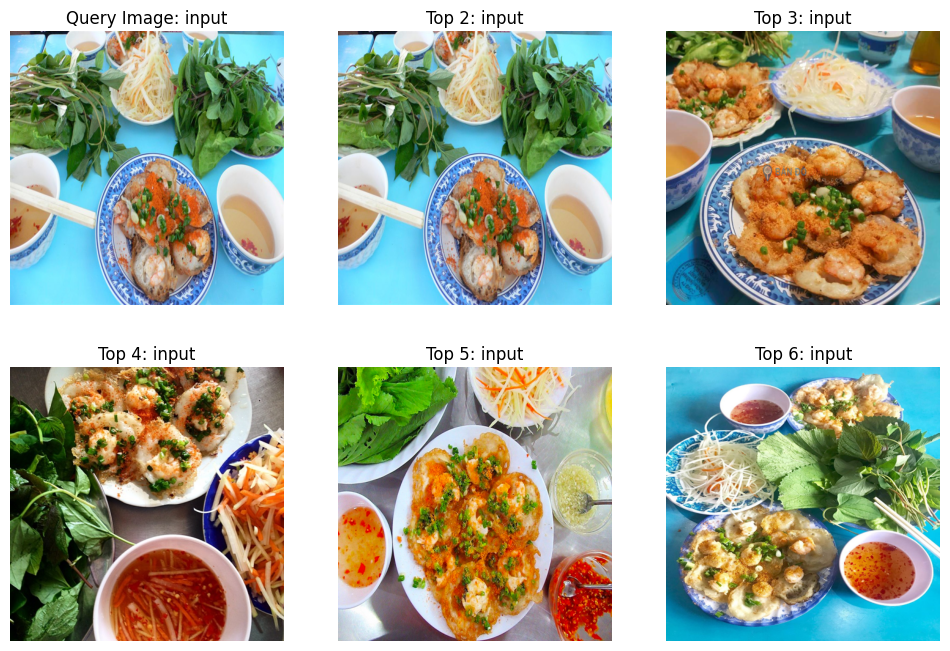

In [41]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)